In [1]:
import numpy as np
import pandas as pd
import os
from shapely.geometry import Point, LineString
import geopandas as gpd
from geopandas import GeoDataFrame
from zipfile import ZipFile
from matplotlib import pyplot as plt
import urllib
%matplotlib inline

In [10]:
!wget https://s3.us-east-2.amazonaws.com/cuspadsdata/yellow_taxi/yellow_201606.csv

--2018-11-08 19:27:03--  https://s3.us-east-2.amazonaws.com/cuspadsdata/yellow_taxi/yellow_201606.csv
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.100.58
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.100.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1748784180 (1.6G) [text/csv]
Saving to: ‘yellow_201606.csv’

yellow_201606.csv   100%[===================>]   1.63G  10.8MB/s    in 2m 41s  

2018-11-08 19:29:44 (10.4 MB/s) - ‘yellow_201606.csv’ saved [1748784180/1748784180]



In [11]:
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile','file.gz')

('file.gz', <http.client.HTTPMessage at 0x11239e128>)

In [12]:
!mv yellow_201606.csv $PUIDATA

In [13]:
!mv file.gz $PUIDATA

In [14]:
zip_result = ZipFile(os.getenv("PUIDATA") + '/' + 'file.gz','r')
zip_result.extractall(os.getenv("PUIDATA") + '/' + 'file')

In [16]:
pumashp = GeoDataFrame.from_file(os.getenv("PUIDATA") + '/' + 'file' +'/geo_export_59d72b95-df5b-4dab-a190-d30a58204164.shp')

In [17]:
pumashp.crs

{'init': 'epsg:4326'}

In [18]:
df = pd.read_csv(os.getenv("PUIDATA") + '/' + 'yellow_201606.csv')
df = df.loc[:100000] #the file is too large
df.dropna(how='any',inplace=True)

In [19]:
df['date'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['day'] = df['date'].dt.day
df = df[df['day']==9]

In [20]:
df['pick'] = list(zip(df.pickup_longitude, df.pickup_latitude))
df['drop'] = list(zip(df.dropoff_longitude, df.dropoff_latitude))

In [21]:
pick = list(zip(df.pickup_longitude, df.pickup_latitude))
drop = list(zip(df.dropoff_longitude, df.dropoff_latitude))

In [22]:
geo = []
geometry = []
for i in range(len(pick)):
    process = [pick[i],drop[i]]
    geo.append(process)
    geometry.append(LineString(geo[i]))

In [23]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

In [24]:
gdf = gdf[(gdf['dropoff_latitude']<41)&(gdf['dropoff_latitude']>40)
          &(gdf['dropoff_longitude']<-72)&(gdf['dropoff_latitude']>-74)
          &(gdf['pickup_latitude']<41)&(gdf['pickup_latitude']>40)
         &(gdf['pickup_longitude']<-72)&(gdf['pickup_longitude']>-74)]


In [25]:
gdf_1 = gdf.sample(n=2000) #only sample 500 trips to plot

ImportError: PySAL is required to use the 'scheme' keyword

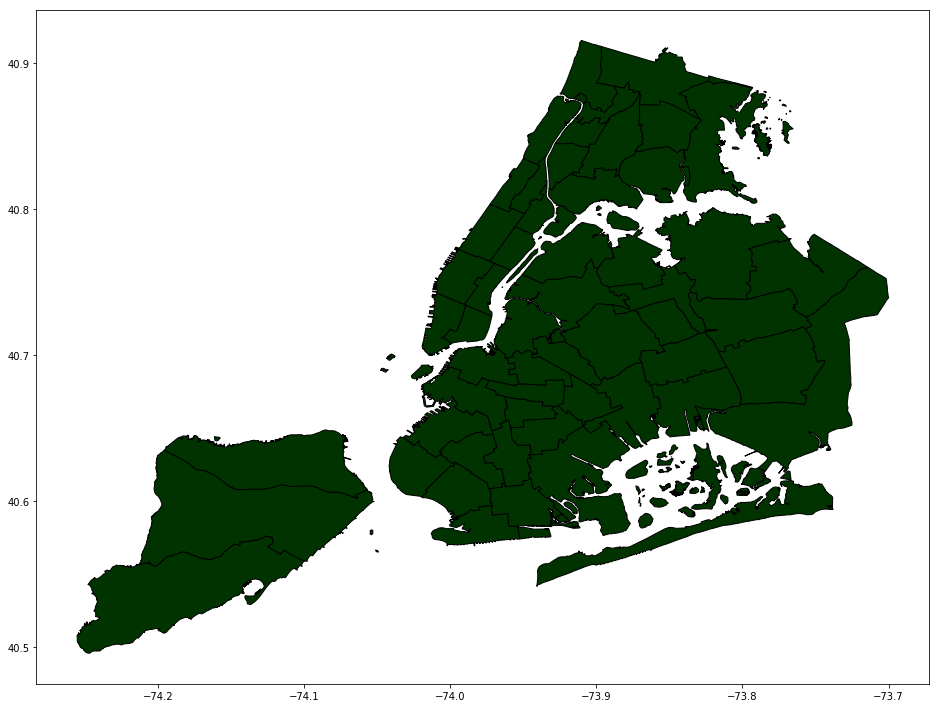

In [26]:
fig,ax = plt.subplots(figsize=(16,16))

pumashp.plot(ax=ax, color='#003300', edgecolor='black')
gdf_1.plot(ax=ax,column='trip_distance',linewidth=0.4,cmap='OrRd',scheme='Equal_interval',legend=True)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.savefig('viz.png')

### Fig 1: This figure shows 2000 randomly chosen yellow taxi trip in 06/09/2016, the more red line means the longer trip distance, the more yellow line means the shorter trip distance. From this plot, we can tell that most taxi trips were within Manhattan, nearly all the long trips were between Manhattan and JFK. The two main destination out of Manhattan is JFK and LaGuardia Airport. There was a relatively active communication between Manhattan and South Brooklyn.

In [27]:
gdf_1.to_file('jsontrip', driver="GeoJSON")

ValueError: Invalid field type <class 'pandas._libs.tslibs.timestamps.Timestamp'>